In [1]:
%matplotlib inline

import imp
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import time
import keras

from keras.datasets import mnist
from keras.models import Model
from keras import optimizers

from matplotlib import cm, transforms

import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

/home/alber/tmp/venv/py3.5/lib/python3.5/site-packages/h5py-2.7.1-py3.5-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Introduction

In this example, we are going to build a sentiment analysis classifer, inspired by experiments in [Arras et al. (2017a)][arras] and [Arras et al. (2017b)][arras2]. In particular, we are going to predict sentiments of movie reviews, and apply explanation methods provided by iNNvestigate to analyze how words in each review influence the review's sentiment prediction.

The dataset that we are going to use is [Standford Sentiment Treebank][standford], which has reviews in five categories: *very negative, negative, neutral, positive,* and *very positive*. In this example, we are interested in building a binary classifier, classifying negative and positive reviews (including their extreme classes). Neutral reviews are excluded. Nevertheless, we still provide a possibilty to build a five-class classifer in Section 2.2.


This example is organized as follows: First, we obtain the dataset from the source as well as pretrained word embedding. Secondly, we prepare the dataset for training a neural network. Then, we construct a neural network model, receiving reviews as input and predicting their sentiments. Finally, we apply various explanation methods implemented in iNNvestigate to explain decisions from a trained model. The figure below is explanations of a review that we expect to see: red indicates a high relevance score in favour of the prediction, while blue is the opposite.

![][sample]

[arras]: http://www.aclweb.org/anthology/W16-1601
[arras2]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181142
[standford]: https://nlp.stanford.edu/sentiment/
[sample]: https://i.imgur.com/IRQL5oh.png

# Data Preparation

## Downloading The Dataset and Word Embedding

In the first step, we download the dataset from `http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip`.

For an *Unix* environment, one can achieve it by using the command below.

In [2]:
%%bash
if [ ! -d "./stanfordSentimentTreebank" ]; then
    curl -L http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip -O && unzip stanfordSentimentTreebank.zip
else
    echo "The data is already there. Skip downloading!!"
fi

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: __MACOSX/
   creating: __MACOSX/stanfordSentimentTreebank/
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._sentiment_labels.txt  
  inflating: stanfordSentimentTreebank/SOStr.txt  
  inflating: stanfo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   329    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6223k  100 6223k    0     0   182k      0  0:00:34  0:00:34 --:--:--  244k


Secondly, as we are going to use an embedding layer as the first layer of our model, embedding weights are required. Fortuanately, there are pretrained word embedding available for this dataset, so we do not need to train it from scratch. The pre-trained embedding is provided by L. Arras at [LRP_for_LSTM][leila_lstm_repo]. Therefore, we can simply download the embedding weights and vocabulary files.
```
- https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/embeddings.npy
- https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/vocab
```

[leila_lstm_repo]: https://github.com/ArrasL/LRP_for_LSTM/tree/master/model

In [3]:
%%bash
if [ ! -e "./stanfordSentimentTreebank/embeddings.npy" ]; then
    curl -L https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/embeddings.npy -o stanfordSentimentTreebank/embeddings.npy &&
        curl -L https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/vocab -o stanfordSentimentTreebank/vocab
else
    echo "The data is already there. Skip downloading!!"
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   147  100   147    0     0     75      0  0:00:01  0:00:01 --:--:--    75
100 9158k  100 9158k    0     0  1039k      0  0:00:08  0:00:08 --:--:-- 1404k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   138  100   138    0     0    232      0 --:--:-- --:--:-- --:--:--   232
100  207k  100  207k    0     0   215k      0 --:--:-- --:--:-- --:--:--  215k


Lastly, due to an encoding issue in the dataset, we need to install the `ftfy` package for fixing the issue.

In [4]:
!pip install ftfy

/bin/sh: 1: pip: not found


In [5]:
from ftfy import fix_encoding

## Data Preprocessing

In [6]:
DATA_PATH = './stanfordSentimentTreebank'

In [7]:
with open('%s/vocab' % DATA_PATH, 'rb') as f:
    vocabs = pickle.load(f) 
    total_vocabs = len(vocabs) 

    # Unknown vocabs are set to <UNK>.
    encoder = dict(zip(['<UNK>'] + vocabs, range(0, len(vocabs) +1)))
    decoder = dict(zip(encoder.values(), encoder.keys()))
    
    print('We have %d vocabs.' % len(encoder))

We have 19539 vocabs.


In [8]:
pretrained_embedding = np.load('%s/embeddings.npy' % DATA_PATH)

# Unknown vocabs will have embedding weights of zero.
embedding = np.zeros((pretrained_embedding.shape[0]+1, pretrained_embedding.shape[1]))
embedding[1:, :] = pretrained_embedding

In [9]:
# load all necessary files
df_reviews = pd.read_csv('%s/datasetSentences.txt' % DATA_PATH, sep='\t')

df_reviews['phase'] = df_reviews.sentence.apply(lambda s: fix_encoding(s))\
    .apply(lambda s: s.replace('-LRB-', '(').replace('-RRB-', ')'))

df_reviews['sostr'] = pd.read_csv('%s/SOStr.txt' % DATA_PATH,
                                  sep='\t',encoding='utf-8',
                                  header=None, names=['sostr']
                                 )

df_reviews['splitset_label'] = pd.read_csv('%s/datasetSplit.txt' % DATA_PATH,
                                           sep=',', header=0
                                          )['splitset_label']


df_phases = pd.read_csv('%s/dictionary.txt' % DATA_PATH,
                        sep='|', names=['phase', 'phase_id']
                       )

df_sentiment_labels = pd.read_csv('%s/sentiment_labels.txt' % DATA_PATH,
                                  sep='|', names=['phase_id', 'sentiment_value'],
                                  header=0
                                 )

df_reviews_with_sentiment_value = df_reviews.merge(df_phases, how='inner', on=['phase'])\
    .merge(df_sentiment_labels, on='phase_id')

df_reviews_with_sentiment_value[:5]

,sentence_index,sentence,phase,sostr,splitset_label,phase_id,sentiment_value
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,The|Rock|is|destined|to|be|the|21st|Century|'s...,1,226166,0.69444
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,The|gorgeously|elaborate|continuation|of|``|Th...,1,226300,0.83333
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,Effective|but|too-tepid|biopic,2,13995,0.51389
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,If|you|sometimes|like|to|go|to|the|movies|to|h...,2,14123,0.73611
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...","Emerges|as|something|rare|,|an|issue|movie|tha...",2,13999,0.86111


Next, we need to decretize `sentiment_values` to labels. According to `./stanfordSentimentTreebank/README.md`, we should use the  below discretization scheme.

| Label | Sentiment Value Range |
|-------|-----------------------|
|   very_negative    |    [0, 0.2]                   |
|    negative   |         (0.2, 0.4]              |
|    neutral   |         (0.4, 0.6]               |
|    positive   |        (0.6, 0.8]               |
|    very_positive   |         (0.8, 1]               |



In [10]:
def sentiment_discretizer(sentiment_value):
    if 0 <= sentiment_value <= 0.2:
        return 'very_negative'
    elif 0.2 < sentiment_value <= 0.4:
        return 'negative'
    elif 0.4 < sentiment_value <= 0.6:
        return 'neutral'
    elif 0.6 < sentiment_value <= 0.8:
        return 'positive'
    elif 0.8 < sentiment_value <= 1:
        return 'very_positive'
    
df_reviews_with_sentiment_value['label'] = df_reviews_with_sentiment_value.sentiment_value.apply(sentiment_discretizer)

In [11]:
df_reviews_with_sentiment_value[:5]

,sentence_index,sentence,phase,sostr,splitset_label,phase_id,sentiment_value,label
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,The|Rock|is|destined|to|be|the|21st|Century|'s...,1,226166,0.69444,positive
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,The|gorgeously|elaborate|continuation|of|``|Th...,1,226300,0.83333,very_positive
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,Effective|but|too-tepid|biopic,2,13995,0.51389,neutral
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,If|you|sometimes|like|to|go|to|the|movies|to|h...,2,14123,0.73611,positive
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...","Emerges|as|something|rare|,|an|issue|movie|tha...",2,13999,0.86111,very_positive


In [12]:
len(df_reviews_with_sentiment_value)

11853

Because the goal of this notebook is to demonstrate how to apply **iNNvestigate** to text, we will simplify the problem (Five-class Classification) to a binary classification. Class 0 will contain very_negative and negative reviews, while Class 1 include very_positive and positive reviews. Neutral reviews are excluded.

In [13]:
LABEL_MAPPING = {
    'very_negative': 0,
    'negative': 0,
    'positive': 1, 
    'very_positive': 1
}

LABEL_IDX_TO_NAME = {
    0: 'negative',
    1: 'positive'
}

In [14]:
# Please use the following mappings for Five-class Classification
# LABEL_MAPPING = dict(zip(['very_negative', 'negative', 'neutral', 'positive', 'very_positive'], range(5)))
# LABEL_IDX_TO_NAME = dict(zip(LABEL_MAPPING.values(), LABEL_MAPPING.keys()))

In [15]:
NUM_CLASSES = len(set(LABEL_MAPPING.values()))
print('We have %d classes.' % NUM_CLASSES)

We have 2 classes.


In [16]:
filtered_indices = df_reviews_with_sentiment_value.label.apply(lambda l: l in LABEL_MAPPING)

df_reviews_with_sentiment_value_filtered = df_reviews_with_sentiment_value.loc[filtered_indices].copy()
df_reviews_with_sentiment_value_filtered.loc[:, 'label_idx'] = df_reviews_with_sentiment_value_filtered.label\
    .apply(lambda l: LABEL_MAPPING[l])

df_reviews_with_sentiment_value_filtered[:5]

,sentence_index,sentence,phase,sostr,splitset_label,phase_id,sentiment_value,label,label_idx
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,The|Rock|is|destined|to|be|the|21st|Century|'s...,1,226166,0.69444,positive,1
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,The|gorgeously|elaborate|continuation|of|``|Th...,1,226300,0.83333,very_positive,1
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,If|you|sometimes|like|to|go|to|the|movies|to|h...,2,14123,0.73611,positive,1
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...","Emerges|as|something|rare|,|an|issue|movie|tha...",2,13999,0.86111,very_positive,1
6,7,Offers that rare combination of entertainment ...,Offers that rare combination of entertainment ...,Offers|that|rare|combination|of|entertainment|...,2,14351,0.83333,very_positive,1


## Spiting Training, Testing, and Validation Set.

In [17]:
SPLIT_LABEL_MAPPING = {
    'training' : 1,
    'testing': 2,
    'validation': 3
}

MAX_SEQ_LENGTH = 40
EMBEDDING_DIM = embedding.shape[1]

In [18]:
def prepare_dataset(ds):
    filtered_indices = df_reviews_with_sentiment_value_filtered.splitset_label == SPLIT_LABEL_MAPPING[ds]
    
    reviews_in_ds = df_reviews_with_sentiment_value_filtered[filtered_indices]
    
    xd = np.zeros((len(reviews_in_ds), MAX_SEQ_LENGTH, EMBEDDING_DIM))
    y = reviews_in_ds.label_idx.values.astype(int)
    
    reviews = []
    for i, sostr in enumerate(reviews_in_ds.sostr.values):
        sostr = sostr.lower()
        review = []
        for j, v in enumerate(sostr.split('|')[:MAX_SEQ_LENGTH]):
            if v in encoder:
                e_idx = encoder[v]
            else:
                e_idx = 0
            
            xd[i, j, :] = embedding[e_idx]
            review.append(e_idx)
        reviews.append(review)
        

    return dict(
        x4d=np.expand_dims(xd, axis=1),
        y=y,
        encoded_reviews=reviews
    )
    

DATASETS = dict()

for ds in ['training', 'testing', 'validation']:
    DATASETS[ds] = prepare_dataset(ds)


In [19]:
len(df_reviews_with_sentiment_value), len(df_reviews_with_sentiment_value_filtered)

(11853, 9612)

In [20]:
print('We have %d reviews in the training set, and %d reviews in the testing set' % 
      (len(DATASETS['training']['x4d']), len(DATASETS['testing']['x4d']))
     )

We have 6920 reviews in the training set, and 1821 reviews in the testing set


In [21]:
sample_idx = 1225

print('Review(ID=%d): %s' %
      (sample_idx, ' '.join(map(lambda x: decoder[x], DATASETS['training']['encoded_reviews'][sample_idx]))))

Review(ID=1225): what it lacks in substance it makes up for in heart .


# Model Construction

Our classifier is a convolutional neural network, which was experimented in [Arras et al. (2017b)][arras2]. As shown below, the architecture has a convoluationa layer, convolving word embeddings of every two words, followed by a max pooling layer and a softmax layer.

![][arch]

[arch]: https://i.imgur.com/YQDfS5P.png
[arras2]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181142

In [22]:
def build_network(input_shape, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
    if activation:
        activation = "relu"

    net = {}
    net["in"] = network_base.input_layer(shape=input_shape)
    net["conv"] = keras.layers.Conv2D(filters=100, kernel_size=(1,2), strides=(1, 1), padding='valid')(net["in"])
    net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, input_shape[2]-1), strides=(1,1))(net["conv"])
    net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["pool"]), units=output_n, activation=activation)
    net["sm_out"] = network_base.softmax(net["out"])


    net.update({
        "input_shape": input_shape,

        "output_n": output_n,
    })
    return net

net = build_network((None, 1, MAX_SEQ_LENGTH, EMBEDDING_DIM), NUM_CLASSES)
model_without_softmax, model_with_softmax = Model(inputs=net['in'], outputs=net['out']), Model(inputs=net['in'], outputs=net['sm_out'])

In [23]:
def to_one_hot(y):
    return keras.utils.to_categorical(y, NUM_CLASSES)

def train_model(model,  batch_size=128, epochs=20):
    
    x_train = DATASETS['training']['x4d']
    y_train = to_one_hot(DATASETS['training']['y'])
    
    x_test = DATASETS['testing']['x4d']
    y_test = to_one_hot(DATASETS['testing']['y'])
    
    x_val = DATASETS['validation']['x4d']
    y_val = to_one_hot(DATASETS['validation']['y'])
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val),
                        shuffle=True
                       )
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [24]:
train_model(model_with_softmax, batch_size=256, epochs=10)

Train on 6920 samples, validate on 871 samples
Epoch 1/10
6920/6920 [==============================] - 1s 145us/step - loss: 0.6041 - acc: 0.7272 - val_loss: 0.5263 - val_acc: 0.7968
Epoch 2/10
6920/6920 [==============================] - 1s 110us/step - loss: 0.4269 - acc: 0.8597 - val_loss: 0.4360 - val_acc: 0.8106
Epoch 3/10
6920/6920 [==============================] - 1s 104us/step - loss: 0.3399 - acc: 0.8747 - val_loss: 0.4111 - val_acc: 0.8083
Epoch 4/10
6920/6920 [==============================] - 1s 112us/step - loss: 0.3035 - acc: 0.8870 - val_loss: 0.4041 - val_acc: 0.8083
Epoch 5/10
6920/6920 [==============================] - 1s 111us/step - loss: 0.2838 - acc: 0.8935 - val_loss: 0.4056 - val_acc: 0.8209
Epoch 6/10
6920/6920 [==============================] - 1s 97us/step - loss: 0.2746 - acc: 0.8975 - val_loss: 0.4039 - val_acc: 0.8140
Epoch 7/10
6920/6920 [==============================] - 1s 104us/step - loss: 0.2628 - acc: 0.9019 - val_loss: 0.4096 - val_acc: 0.8197
Ep

In [25]:
model_without_softmax.set_weights(model_with_softmax.get_weights())

# Model Analysis and Visualization

At this stage, we have a trained model and are ready to explain it via **iNNvestigate**'s analyzers.

In [28]:
# Specify methods that you would like to use to explain the model. 
# Please refer to iNNvestigate's documents for available methods.
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'pattern.attribution']
kwargs = [{}, {}, {}, {'pattern_type': 'relu'}]

In [31]:
# build an analyzer for each method
analyzers = []

for method, kws in zip(methods, kwargs):
    analyzer = innvestigate.create_analyzer(method, model_without_softmax, **kws)
    analyzer.fit(DATASETS['training']['x4d'], batch_size=256, verbose=1)
    analyzers.append(analyzer)

/home/alber/repos/innvestigate/innvestigate/analyzer/base.py:136: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


Epoch 1/1
28/28 [==============================] - 2s 76ms/step - loss: 2.0000 - broadcast_3_loss: 1.0000 - broadcast_4_loss: 1.0000


In [32]:
# specify indices of reviews that we want to investigate
test_sample_indices = [97, 175, 1793, 1186, 354, 1043]

test_sample_preds = [None]*len(test_sample_indices)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_indices), len(analyzers), 1, MAX_SEQ_LENGTH])

for i, ridx in enumerate(test_sample_indices):

    x, y = DATASETS['testing']['x4d'][ridx], DATASETS['testing']['y'][ridx]

    t_start = time.time()
    x = x.reshape((1, 1, MAX_SEQ_LENGTH, EMBEDDING_DIM))    

    presm = model_without_softmax.predict_on_batch(x)[0] #forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    test_sample_preds[i] = y_hat
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)

        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review %d (%.4fs)'% (ridx, t_elapsed))

Review 97 (2.3509s)
Review 175 (0.0063s)
Review 1793 (0.0058s)
Review 1186 (0.0068s)
Review 354 (0.0061s)
Review 1043 (0.0060s)


## Visualization

To this point, we have all analysis results from iNNvestigate's analyzers, and we are now ready to visualize them in a insightful way. We will use relevance scores from explanation methods to highlight the words in each review. 

We will use  the *blue-white-red (bwr)* color map for this purpose. Hence, words that have a positive score to the prediction are be shaded in *red*, while  negative-contribution or zero-contribution words are then highlighted in *blue*, and *white*, respectively.


In [33]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')


### An Example of  The Visualization
Let assume we have this review `I really love this movie but not in the beginning`. It is predicted as `positive`, and the relevance scores are distributed as follows: 

```
        I 0.20
    really 0.20
      love 0.50
      this 0.10
     movie 0.10
       but 0.10
       not -0.20
        in 0.05
       the 0.05
 beginning 0.08
```

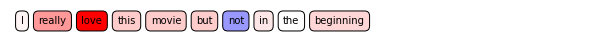

In [34]:
plot_text_heatmap(
    "I really love this movie but not in the beginning".split(' '),
    np.array([0.02, 0.2, 0.5, 0.1, 0.1, 0.1, -0.2, 0.05, 0.00, 0.08])
)

# "love" is shaded with strong red because its relevance score is rather high
# "not" is highlighted in light blue because of its negative score.

Review(id=97): this may not have the dramatic gut-wrenching impact of other holocaust films , but it 's a compelling story , mainly because of the way it 's told by the people who were there .
Pred class : positive ✓


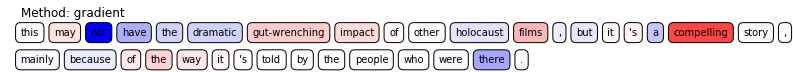

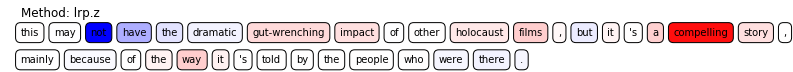

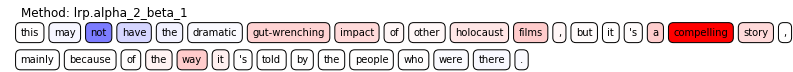

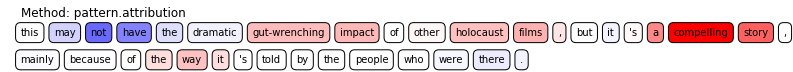

Review(id=175): without heavy-handedness , dong provides perspective with his intelligent grasp of human foibles and contradictions .
Pred class : positive ✓


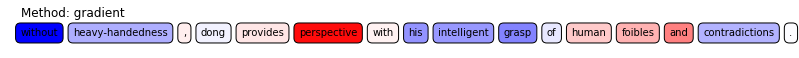

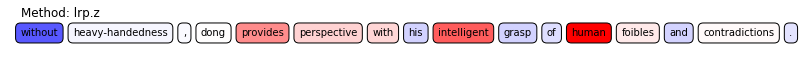

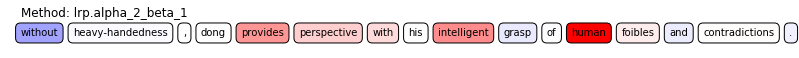

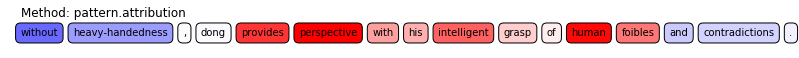

Review(id=1793): a frantic search for laughs , with a hit-to-miss ratio that does n't exactly favour the audience .
Pred class : negative ✓


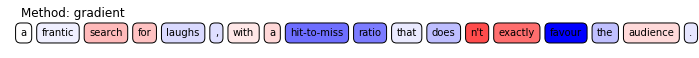

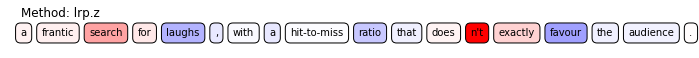

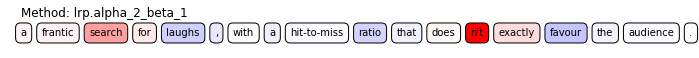

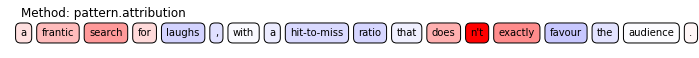

Review(id=1186): what you would end up with if you took orwell , bradbury , kafka , george lucas and the wachowski brothers and threw them into a blender .
Pred class : negative ✗ (positive)


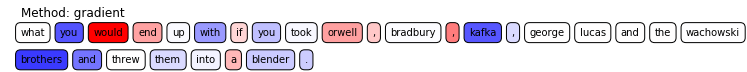

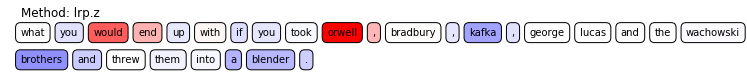

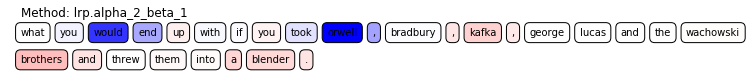

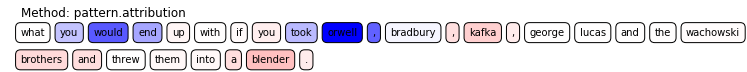

Review(id=354): a charming yet poignant tale of the irrevocable ties that bind .
Pred class : positive ✓


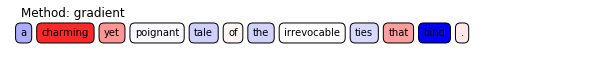

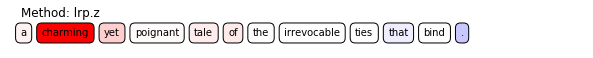

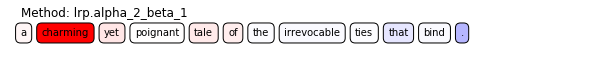

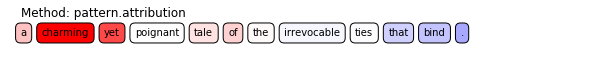

Review(id=1043): but he loses his focus when he concentrates on any single person .
Pred class : negative ✓


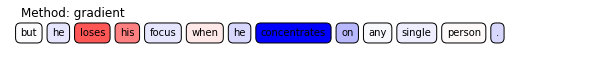

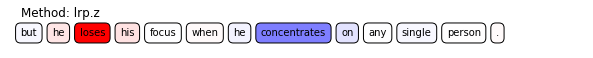

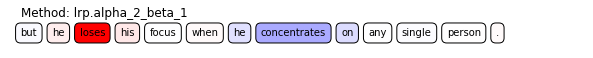

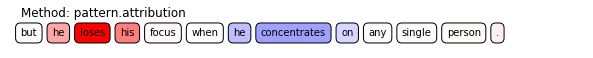

In [35]:
# Traverse over the analysis results and visualize them.
for i, idx in enumerate(test_sample_indices):

    words = [decoder[t] for t in list(DATASETS['testing']['encoded_reviews'][idx])]
    
    print('Review(id=%d): %s' % (idx, ' '.join(words)))
    y_true = DATASETS['testing']['y'][idx]
    y_pred = test_sample_preds[i]

    print("Pred class : %s %s" %
          (LABEL_IDX_TO_NAME[y_pred], '✓' if y_pred == y_true else '✗ (%s)' % LABEL_IDX_TO_NAME[y_true])
         )
                                
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), title='Method: %s' % method, verbose=0)
        plt.show()